In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy import sparse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from joblib import cpu_count

In [2]:
n_jobs = cpu_count()
print(f"Number of available jobs (CPU cores): {n_jobs}")

# Set working directory
os.chdir("C:/Users/Jose Guevara/Desktop/GitHub_Clones/challenges/main/Credit-Risk-Analysis/loan/")
# Load dataset with multi-index
df = pd.read_csv('loan.csv', low_memory=False, index_col=[0, 1])
print(df.head())

Number of available jobs (CPU cores): 24
                   loan_amnt  funded_amnt  funded_amnt_inv        term  \
id      member_id                                                        
1077501 1296599       5000.0       5000.0           4975.0   36 months   
1077430 1314167       2500.0       2500.0           2500.0   60 months   
1077175 1313524       2400.0       2400.0           2400.0   36 months   
1076863 1277178      10000.0      10000.0          10000.0   36 months   
1075358 1311748       3000.0       3000.0           3000.0   60 months   

                   int_rate  installment grade sub_grade  \
id      member_id                                          
1077501 1296599       10.65       162.87     B        B2   
1077430 1314167       15.27        59.83     C        C4   
1077175 1313524       15.96        84.33     C        C5   
1076863 1277178       13.49       339.31     C        C1   
1075358 1311748       12.69        67.79     B        B5   

                   

In [3]:
# Step 1: Data Information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 887379 entries, (1077501, 1296599) to (36271262, 38982659)
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    887379 non-null  float64
 1   funded_amnt                  887379 non-null  float64
 2   funded_amnt_inv              887379 non-null  float64
 3   term                         887379 non-null  object 
 4   int_rate                     887379 non-null  float64
 5   installment                  887379 non-null  float64
 6   grade                        887379 non-null  object 
 7   sub_grade                    887379 non-null  object 
 8   emp_title                    835917 non-null  object 
 9   emp_length                   842554 non-null  object 
 10  home_ownership               887379 non-null  object 
 11  annual_inc                   887375 non-null  float64
 12  verifi

In [4]:
# Step 2: Missing Values Summary
na_counts = df.isna().sum()
na_percentage = (na_counts / len(df)) * 100
na_summary = pd.DataFrame({
    'Missing Values': na_counts,
    'Percentage': na_percentage
})
na_summary = na_summary[na_summary['Missing Values'] > 0]
print("\nColumns with Missing Values:")
print(na_summary.sort_values(by="Percentage", ascending=False))


Columns with Missing Values:
                             Missing Values  Percentage
dti_joint                            886870   99.942640
annual_inc_joint                     886868   99.942415
verification_status_joint            886868   99.942415
il_util                              868762   97.902024
mths_since_rcnt_il                   866569   97.654892
total_cu_tl                          866007   97.591559
inq_fi                               866007   97.591559
all_util                             866007   97.591559
max_bal_bc                           866007   97.591559
open_rv_24m                          866007   97.591559
open_rv_12m                          866007   97.591559
total_bal_il                         866007   97.591559
open_il_24m                          866007   97.591559
open_il_12m                          866007   97.591559
open_il_6m                           866007   97.591559
open_acc_6m                          866007   97.591559
inq_last_12m      

In [5]:
# Step 3: Drop columns with more than 10% missing values, but keep 'loan_status'
columns_to_drop = na_summary[(na_summary['Percentage'] > 10) & (na_summary.index != 'loan_status')].index
df_cleaned = df.drop(columns=columns_to_drop)
print(f"\nColumns dropped (more than 10% missing values): \n{list(columns_to_drop)}")


Columns dropped (more than 10% missing values): 
['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [6]:
# Step 4: Drop rows with any remaining missing values
df_cleaned = df_cleaned.dropna()

In [7]:
# Step 5: Context-Based Grouping of 'loan_status'
df_cleaned['loan_status_grouped'] = df_cleaned['loan_status'].replace({
    'Fully Paid': 'No Risk',
    'Does not meet the credit policy. Status:Fully Paid': 'No Risk',
    'Charged Off': 'Risk',
    'Default': 'Risk',
    'Does not meet the credit policy. Status:Charged Off': 'Risk',
    'Late (31-120 days)': 'Risk',
    'Late (16-30 days)': 'Risk',
    'In Grace Period': 'Risk',
    'Current': 'Risk',
    'Issued': 'Other'  # Grouping low representation into 'Other'
})

In [8]:
# Drop the "Other" class
df_cleaned = df_cleaned[df_cleaned['loan_status_grouped'] != 'Other']

In [9]:
# Check the class counts after dropping "Other"
loan_status_grouped_counts = df_cleaned['loan_status_grouped'].value_counts()
print("\nLoan Status Grouped Counts after dropping 'Other':")
print(loan_status_grouped_counts)

# Step 6: Encode the grouped 'loan_status' (No Risk = 0, Risk = 1)
df_cleaned['loan_status_encoded'] = df_cleaned['loan_status_grouped'].map({'No Risk': 0, 'Risk': 1})


Loan Status Grouped Counts after dropping 'Other':
loan_status_grouped
Risk       606365
No Risk    146532
Name: count, dtype: int64


In [10]:
# Step 7: Identify Multicollinearity using VIF
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
X_numeric = df_cleaned[numeric_cols]

vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]

print("\nVariance Inflation Factor (VIF) for Numeric Features:")
print(vif_data.sort_values(by="VIF", ascending=False))


Variance Inflation Factor (VIF) for Numeric Features:
                       Feature           VIF
16                 total_pymnt  8.497358e+13
18             total_rec_prncp  6.169315e+13
19               total_rec_int  5.976907e+12
21                  recoveries  2.044025e+11
20          total_rec_late_fee  2.048781e+07
1                  funded_amnt  7.589954e+06
2              funded_amnt_inv  4.514513e+06
14                   out_prncp  4.271503e+06
15               out_prncp_inv  4.271198e+06
0                    loan_amnt  3.084454e+06
17             total_pymnt_inv  2.895127e+06
25                 policy_code  4.567623e+01
4                  installment  1.169803e+01
11                   revol_bal  4.648516e+00
29            total_rev_hi_lim  4.475771e+00
23             last_pymnt_amnt  4.126096e+00
22     collection_recovery_fee  3.245631e+00
30         loan_status_encoded  2.759000e+00
9                     open_acc  2.173666e+00
13                   total_acc  2.138248e+00


In [11]:
# Separate features and target variable
X = df_cleaned.drop(columns=['loan_status', 'loan_status_grouped', 'loan_status_encoded'])
y = df_cleaned['loan_status_encoded']

In [12]:
# Function to reduce cardinality for categorical features
def reduce_cardinality(series, threshold=0.05):
    value_counts = series.value_counts(normalize=True)
    to_combine = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in to_combine else x)

In [13]:
# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"Training set size before SMOTE: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size before SMOTE: 602317 samples
Test set size: 150580 samples


In [14]:
# Step 9: Scale numeric features
numeric_cols = X_train.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_numeric_train = scaler.fit_transform(numeric_cols)
scaled_numeric_test = scaler.transform(X_test[numeric_cols.columns])

# Convert scaled numeric data to sparse matrices
scaled_numeric_train_sparse = sparse.csr_matrix(scaled_numeric_train)
scaled_numeric_test_sparse = sparse.csr_matrix(scaled_numeric_test)

In [15]:
# Step 10: Handle Categorical Features - Reduce Cardinality and One-Hot Encode
categorical_cols = X_train.select_dtypes(include=['object']).columns
df_reduced_train = X_train[categorical_cols].apply(reduce_cardinality)
df_reduced_test = X_test[categorical_cols].apply(reduce_cardinality)

encoder = OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')
encoded_categorical_train_sparse = encoder.fit_transform(df_reduced_train)
encoded_categorical_test_sparse = encoder.transform(df_reduced_test)

# Combine the scaled numeric features with the one-hot encoded categorical data
X_train_encoded_sparse = sparse.hstack([scaled_numeric_train_sparse, encoded_categorical_train_sparse])
X_test_encoded_sparse = sparse.hstack([scaled_numeric_test_sparse, encoded_categorical_test_sparse])

c:\Users\Jose Guevara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
# Step 11: Convert data to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.FloatTensor(X_train_encoded_sparse.toarray()).to(device)
X_test_tensor = torch.FloatTensor(X_test_encoded_sparse.toarray()).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

In [17]:
# Step 12: Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [18]:
# Step 13: Define the ANN model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)  # For binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.output(x)
        return x

# Step 14: Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    y_pred_prob = []
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            y_true.extend(y_batch.cpu().numpy())  # Append true labels
            y_pred.extend(predicted.cpu().numpy())  # Append predicted labels
            y_pred_prob.extend(outputs.cpu().numpy())  # Append raw probabilities
    
    return y_true, y_pred, y_pred_prob


In [19]:
# Step 15: Dynamically compute class weights from the training labels
class_counts = torch.bincount(y_train_tensor)
class_weights = 1. / class_counts.float()
class_weights = class_weights.to(device)

In [20]:
# Step 16: Initialize the model, loss function, and optimizer
input_dim = X_train_encoded_sparse.shape[1]
model = ANNModel(input_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.7, weight_decay=1e-4, nesterov=True)

In [21]:
# Step 17: Training with early stopping
def train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, epochs=200, patience=10):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        
        # Evaluate on test set for early stopping
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        
        # Check early stopping condition
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Validation loss didn't improve for {patience} epochs.")
            break


In [22]:
# Step 18: Train the model
train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, epochs=200, patience=10)

Epoch [1/200], Loss: 0.6896
Epoch [2/200], Loss: 0.6412
Epoch [3/200], Loss: 0.2934
Epoch [4/200], Loss: 0.0664
Epoch [5/200], Loss: 0.0401
Epoch [6/200], Loss: 0.0322
Epoch [7/200], Loss: 0.0275
Epoch [8/200], Loss: 0.0246
Epoch [9/200], Loss: 0.0226
Epoch [10/200], Loss: 0.0210
Epoch [11/200], Loss: 0.0197
Epoch [12/200], Loss: 0.0187
Epoch [13/200], Loss: 0.0178
Epoch [14/200], Loss: 0.0170
Epoch [15/200], Loss: 0.0164
Epoch [16/200], Loss: 0.0159
Epoch [17/200], Loss: 0.0153
Epoch [18/200], Loss: 0.0149
Epoch [19/200], Loss: 0.0145
Epoch [20/200], Loss: 0.0142
Epoch [21/200], Loss: 0.0139
Epoch [22/200], Loss: 0.0136
Epoch [23/200], Loss: 0.0133
Epoch [24/200], Loss: 0.0131
Epoch [25/200], Loss: 0.0128
Epoch [26/200], Loss: 0.0126
Epoch [27/200], Loss: 0.0125
Epoch [28/200], Loss: 0.0123
Epoch [29/200], Loss: 0.0120
Epoch [30/200], Loss: 0.0119
Epoch [31/200], Loss: 0.0118
Epoch [32/200], Loss: 0.0116
Epoch [33/200], Loss: 0.0115
Epoch [34/200], Loss: 0.0113
Epoch [35/200], Loss: 0

In [23]:
# Step 19: Evaluate the model
y_true, y_pred, y_pred_prob = evaluate_model(model, test_loader)

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

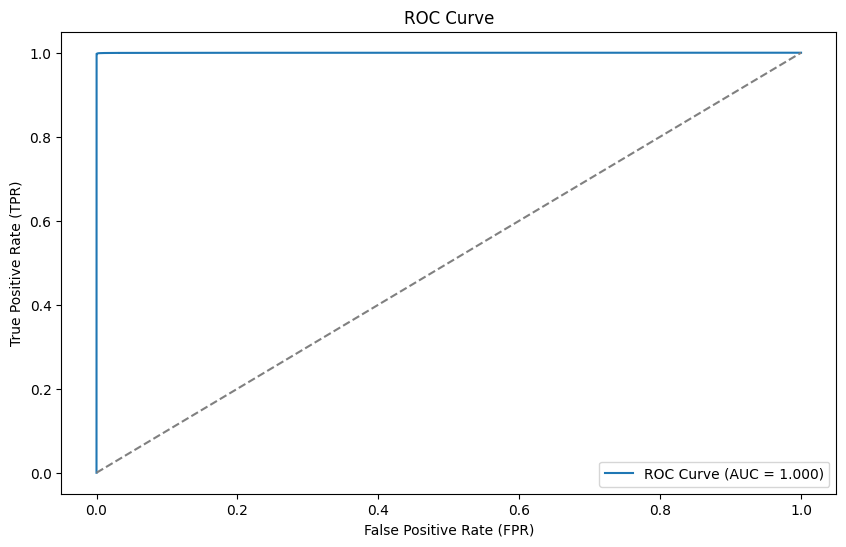


ANN Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29315
           1       1.00      1.00      1.00    121265

    accuracy                           1.00    150580
   macro avg       1.00      1.00      1.00    150580
weighted avg       1.00      1.00      1.00    150580


Confusion Matrix:
[[ 29279     36]
 [   224 121041]]


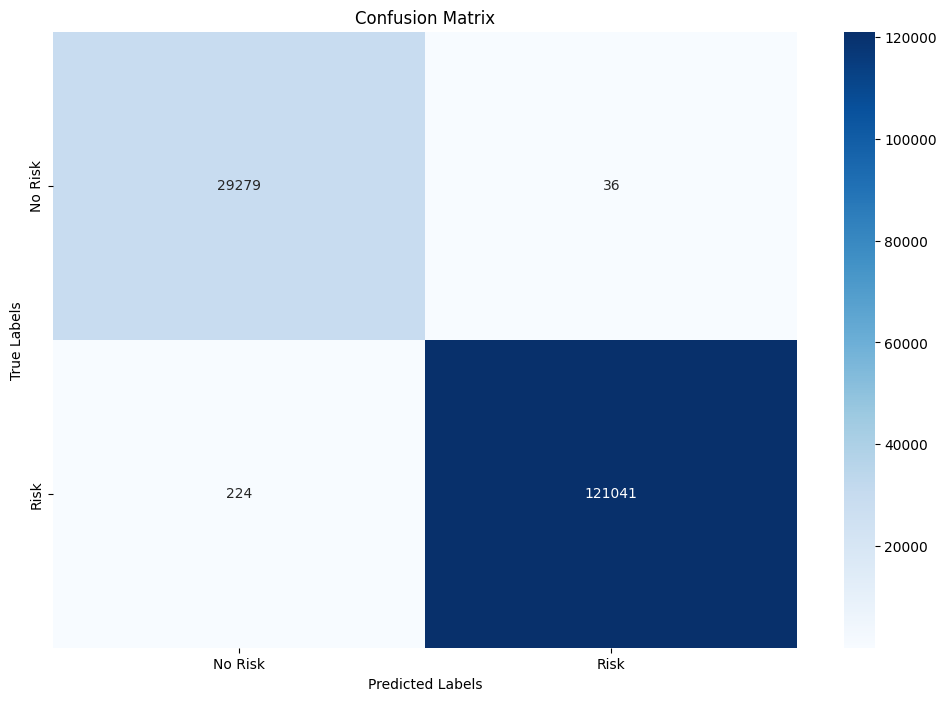

In [34]:
# Convert predictions to probabilities using sigmoid for binary classification
y_pred_prob = torch.sigmoid(torch.FloatTensor(y_pred_prob)).numpy()

# Step 20: Calculate AUC-ROC and plot ROC curve
roc_auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

# Step 22: Print classification report
print("\nANN Classification Report on Test Data:")
print(classification_report(y_true, y_pred))

# Step 23: Generate confusion matrix and plot
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
class_names = ['No Risk', 'Risk']  # Define class names according to your model's output
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [33]:
# Step 24: Extract metrics from confusion matrix
confusion_matrix_array = np.array(conf_matrix)
tp = np.diag(confusion_matrix_array)  # True Positives (Diagonal elements)
fp = confusion_matrix_array.sum(axis=0) - tp  # False Positives (Sum of each column - True Positives)
fn = confusion_matrix_array.sum(axis=1) - tp  # False Negatives (Sum of each row - True Positives)
tn = confusion_matrix_array.sum() - (fp + fn + tp)  # True Negatives

# Sensitivity (Recall) for each class: TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity for each class: TN / (TN + FP)
specificity = tn / (tn + fp)

# Precision for each class: TP / (TP + FP)
precision = tp / (tp + fp)

# F1 Score for each class: 2 * (Precision * Recall) / (Precision + Recall)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

# Organizing the metrics into a dictionary and rounding to 3 decimal places
metrics = {
    "Sensitivity (Recall)": np.round(sensitivity, 3),
    "Specificity": np.round(specificity, 3),
    "Precision": np.round(precision, 3),
    "F1 Score": np.round(f1, 3)
}

# Creating the DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Display the rounded metrics DataFrame
print("\nMetrics Summary:")
print(metrics_df)

# Step 25: Print AUC values
print(f'ROC AUC: {roc_auc:.3f}')


Metrics Summary:
   Sensitivity (Recall)  Specificity  Precision  F1 Score
0                 0.999        0.998      0.992     0.996
1                 0.998        0.999      1.000     0.999
ROC AUC: 1.000
